# Package

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import glob as glob
import os

# Set directory

In [2]:
#os.chdir('.\\Ez')
os.getcwd()

'C:\\Users\\wqysb\\Google Drive\\papers\\Au SiO2 100\\Au_SiOx\\Comsol_export\\Ez'

# Import and filter data

In [6]:
def get_file_names():
    return glob.glob('*data*.txt')

def read_and_filter_plot_data(yrange, zrange, f):
    data = pd.read_csv(f, skiprows = 9, sep='\s+', names=['y','z','Ez'])
    yfilter = np.logical_and(data.y<=yrange[0], data.y>=yrange[1])
    zfilter = np.logical_and(data.z<=zrange[0], data.z>=zrange[1])
    yzf = np.logical_and(yfilter, zfilter)
    fdata = data[yzf].copy().reset_index(drop=True)
    return fdata

def read_and_filter_raw_data(xcoor, yrange, zrange, f):
    data = pd.read_csv(f, skiprows = 9, sep='\s+', names=['x', 'y','z','Ez'])
    yfilter = np.logical_and(data.y<=yrange[0], data.y>=yrange[1])
    zfilter = np.logical_and(data.z<=zrange[0], data.z>=zrange[1])
    yzf = np.logical_and(yfilter, zfilter)
    fdata = data[data.x==xcoor][yzf].copy().reset_index(drop=True)
    return fdata

def data_dict(yrange, fnlist, raw=False):
    dlist = {}
    
    if not raw:
        for f in fnlist:
            SiO_t = float(f.split('_')[2])
            zrange = [SiO_t+0.4, SiO_t-0.2]
            print(zrange)
            dlist[SiO_t] = read_and_filter_plot_data(yrange, zrange, f)
    else:
        xcoor = float(input('x coordinate: '))
        for f in fnlist:
            SiO_t = float(f.split('_')[2])
            zrange = [SiO_t+0.4, SiO_t-0.2]
            print(zrange)
            dlist[SiO_t] = read_and_filter_raw_data(xcoor, yrange, zrange, f)
    return dlist

In [7]:
file = get_file_names()
dl = data_dict([1.5, -1.5], file, True)

x coordinate: 0
[1.4, 0.8]


C:\Users\wqysb\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [8]:
for v in dl.values():
    print(v.z.min())

0.8035899999999999


# Remove cycle and interpolate

In [15]:
def remove_particle(r, data_dict):
    # make the grid and remove the particle area, return a dictionary of grids with key is the thickness of SiOx
    grid_dict = {}
    for k, v in data_dict.items():
        points = np.transpose([v.y, v.z])
        values = v.Ez.values
        
        y_min, y_max = v.y.min(), v.y.max()
        z_min, z_max = v.z.min(), v.z.max()
        # the range of area
        y0, z0 = 0.0, k + r # coordinate of the center of particle
        
        grid_y0, grid_z0 = np.mgrid[y_min:y_max:30000j, z_min:z_max:6000j] # make the grid matrix
        
        # use complex number to help setup the grid mask
        grid = grid_y0 + 1.j * grid_z0
        center = y0 + 1.j * z0

        # Set inside the particle to NaN to remove the particle
        grid_mask = np.less_equal(abs(grid - center), r)
        grid[grid_mask] = np.nan
        grid_y1, grid_z1 = grid.real, grid.imag
        
        grid_z2 = griddata(points, values, (grid_y1, grid_z1), method='linear') # interpolate the Ez in the grid with particle removed
        
        grid_dict[k] = grid_z2
    
    return grid_dict

In [16]:
gl = remove_particle(1.1, dl)

In [11]:
gl[1.0][~np.isnan(gl[1.0])].min()

-12106415694.96226

In [12]:
sorted(gl.keys())

[1.0]

# Plotting

In [13]:
def plot_Ez(grid_dict):
    num_of_sample = len(grid_dict)
    rows = num_of_sample//3+1
    i = 1
    sorted_key_list = sorted(list(grid_dict))
    vma=grid_dict[1.0][~np.isnan(grid_dict[1.0])].max()
    vmi=grid_dict[1.0][~np.isnan(grid_dict[1.0])].min()*0.25
    plt.figure(figsize=(20,rows*2))
    for k in sorted_key_list:
        plt.subplot(rows, 3, i, title=str(k))
        plt.imshow(np.transpose(gl[k]), extent=[-1.5, 1.5, -0.2, 0.3], origin='lower', vmin=vmi, vmax=vma)
        i=i+1
    plt.show()

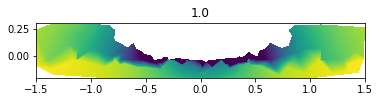

In [17]:
plot_Ez(gl)

# Export